In [1]:
import sys, os 
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))

# @title Imports
import dataclasses
import datetime
import functools
import math
import re
from typing import Optional
from glob import glob

import cartopy.crs as ccrs
#from google.cloud import storage
from wofscast import autoregressive
from wofscast import casting
from wofscast import checkpoint
from wofscast import data_utils
from wofscast import my_graphcast as graphcast
from wofscast import normalization
from wofscast import rollout
from wofscast import xarray_jax
from wofscast import xarray_tree
from wofscast.data_generator import load_wofscast_data, wofscast_data_generator, to_static_vars
from wofscast.wofscast_task_config import WOFS_TASK_CONFIG, train_lead_times, TARGET_VARS

from IPython.display import HTML
import ipywidgets as widgets
import haiku as hk
import jax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import xarray #as xr

from wofscast.utils import count_total_parameters, save_model_params, load_model_params 

# For training the weights!
import optax
import jax
import numpy as np
import jax.numpy as jnp

from jax import device_put
from jax import pmap, device_put, local_device_count
# Check available devices
print("Available devices:", jax.devices())
from jax import tree_util


import time 

Available devices: [cuda(id=0), cuda(id=1)]


### Functions for using Multiple GPUs

1. spliting xarray dataset into the number of devices


In [22]:
def shard_xarray_dataset(dataset, num_devices=None):
    """
    Shards an xarray.Dataset across multiple GPUs.

    Parameters:
    - dataset: xarray.Dataset to be sharded.
    - num_devices: Number of GPUs to shard the dataset across. If None, uses all available GPUs.

    Returns:
    A list of sharded xarray.Dataset, one for each GPU.
    """
    if num_devices is None:
        num_devices = jax.local_device_count()

    # Assuming the first dimension of each data variable is the batch dimension
    batch_size = next(iter(dataset.data_vars.values())).shape[0]
    shard_size = batch_size // num_devices

    if batch_size % num_devices != 0:
        raise ValueError(f"Batch size {batch_size} is not evenly divisible by the number of devices {num_devices}.")

    sharded_datasets = []
    for i in range(num_devices):
        start_idx = i * shard_size
        end_idx = start_idx + shard_size
        # Use dataset.isel to select a subset of the batch dimension for each shard
        shard = dataset.isel(indexers={'batch': slice(start_idx, end_idx)})
        sharded_datasets.append(shard)

    return xarray.concat(sharded_datasets, dim='devices')

def replicate_for_devices(params, num_devices=None):
    """Replicate parameters for each device using jax.device_put_replicated."""
    if num_devices is None:
        num_devices = jax.local_device_count()
    #devices = jax.devices()[:num_devices]
    #replicated = jax.device_put_replicated(params, devices)
    
    return jax.tree_map(lambda x: jnp.array([x] * num_devices), params)
    
    #return replicated


In [50]:
def add_diagnostics(accum_diagnostics, diagnostics, ind): 
    """Append the diagnostics from each epoch"""
    for var, val in diagnostics.items():
        accum_diagnostics[var][ind] = float(val)
  
    return accum_diagnostics

def compute_avg_diagnostics(diag_list, target_vars):
    temp_dict = {v : [] for v in target_vars}
    for diag in diag_list: 
        for v in target_vars:
            temp_dict[v].append(float(diag[v]))
            
    final_dict = {v: np.mean(temp_dict[v]) for v in target_vars}

    return final_dict

def plot_diagnostics(accum_diag, ind):
    fig, ax = plt.subplots(dpi=300, figsize=(6,4))
    for v in accum_diag.keys():
        line, = ax.plot(accum_diag[v], label=v)
        y = accum_diag[v][-1]  # Last value in the series
        x = len(accum_diag[v]) - 1  # Last index
        
        ax.annotate(v, xy=(x, y), xytext=(5,5), textcoords="offset points",
                    color=line.get_color(), fontsize=6)

            
    ax.set(xlabel='Epoch', ylabel='Loss', xlim=[0, x+5], title=f'Diagnostic Phase {ind}')
    ax.grid(alpha=0.5)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.savefig(f'diagnostics_{ind}.png')


def construct_wrapped_graphcast(model_config: graphcast.ModelConfig, 
                                task_config: graphcast.TaskConfig,
                                #norm_stats: dict
                               ):
    """Constructs and wraps the GraphCast Predictor."""
    # Deeper one-step predictor.
    predictor = graphcast.GraphCast(model_config, task_config)

    # Modify inputs/outputs to `graphcast.GraphCast` to handle conversion to
    # from/to float32 to/from BFloat16.
    predictor = casting.Bfloat16Cast(predictor)

    # Modify inputs/outputs to `casting.Bfloat16Cast` so the casting to/from
    # BFloat16 happens after applying normalization to the inputs/targets.

    predictor = normalization.InputsAndResiduals(
      predictor,
      #diffs_stddev_by_level=norm_stats['diffs_stddev_by_level'],
      #mean_by_level=norm_stats['mean_by_level'],
      #stddev_by_level=norm_stats['stddev_by_level']
     diffs_stddev_by_level=diffs_stddev_by_level,
      mean_by_level=mean_by_level,
      stddev_by_level=stddev_by_level
    )

    # Wraps everything so the one-step model can produce trajectories.
    predictor = autoregressive.Predictor(predictor, gradient_checkpointing=True)
    
    return predictor


@hk.transform_with_state
def run_forward(model_config, task_config, inputs, targets_template, forcings):
    predictor = construct_wrapped_graphcast(model_config, task_config)
    return predictor(inputs, targets_template=targets_template, forcings=forcings)


@hk.transform_with_state
def loss_fn(model_config, task_config, inputs, targets, forcings):
    predictor = construct_wrapped_graphcast(model_config, task_config)
    loss, diagnostics = predictor.loss(inputs, targets, forcings)
    return xarray_tree.map_structure(
      lambda x: xarray_jax.unwrap_data(x.mean(), require_jax=True),
      (loss, diagnostics))
    
    
def modify_path_if_exists(original_path):
    """
    Modifies the given file path by appending a version number if the path already exists.
    Useful for not overwriting existing version of the WoFSCast model parameters. 

    Args:
        original_path (str): The original file path.

    Returns:
        str: A modified file path if the original exists, otherwise returns the original path.
    """
    # Check if the file exists
    if not os.path.exists(original_path):
        return original_path

    # Split the path into directory, basename, and extension
    directory, filename = os.path.split(original_path)
    basename, extension = os.path.splitext(filename)

    # Iteratively modify the filename by appending a version number until an unused name is found
    version = 1
    while True:
        new_filename = f"{basename}_v{version}{extension}"
        new_path = os.path.join(directory, new_filename)
        if not os.path.exists(new_path):
            return new_path
        version += 1


class WoFSCastTrainer:
    """
    A class for training the WoFSCast model, designed to predict weather phenomena using
    the same Graph Neural Network (GNN) approach for GraphCast. The training process is divided into three phases, 
    each with its own number of epochs. The model supports multi-GPU training (unsupported at the moment) and periodic 
    checkpointing.

    Parameters:
    - mesh_size (int): The number of mesh subdivisions. Starting an initial 4 triangle mesh, continually 
                        divide based on mesh_size
    - latent_size (int): The size of the latent vectors in the GNN.
    - gnn_msg_steps (int): The number of message passing steps in the GNN.
    - hidden_layers (int): The number of hidden layers in the GNN. Each layer has the same latent_size
    - grid_to_mesh_node_dist (int): The search distance linking grid points and mesh nodes for the first GNN. 
                                    Value is grid point distance; not physical distance. 
    - n_epochs_phase1 (int): The number of training epochs for phase 1.
    - n_epochs_phase2 (int): The number of training epochs for phase 2.
    - n_epochs_phase3 (int): The number of training epochs for phase 3.
    - total_timesteps (int): The total number of prediction timesteps.
    - batch_size (int): The batch size used for training.
    - checkpoint (bool): Whether to checkpoint the model during training.
    - norm_stats_path (str): The file path for the normalization statistics.
    - out_path (str): The output path for the trained model and checkpoints.
    - checkpoint_interval (int): The interval (in epochs) between checkpoints.
    - use_multi_gpus (bool): Whether to use multiple GPUs for training.
    - verbose (int): Verbosity level for logging.

    Methods:
    __init__: Initializes the WoFSCastTrainer instance with the given parameters, ensuring
              not to overwrite existing models, and preparing the model for training.
    """
    
    def __init__(self, 
                 mesh_size=3, 
                 latent_size=32, 
                 gnn_msg_steps=4, 
                 hidden_layers=1, 
                 grid_to_mesh_node_dist=5,
                 n_epochs_phase1 = 5, 
                 n_epochs_phase2 = 5,
                 n_epochs_phase3 = 10,
                 total_timesteps = 12, 
                 batch_size=200,
                 checkpoint=True,
                 norm_stats_path = '/work/mflora/wofs-cast-data/normalization_stats', 
                 out_path = '/work/mflora/wofs-cast-data/model/wofscast.npz',
                 checkpoint_interval = 100,
                 use_multi_gpus=False, verbose=2
                ):
        
        self.verbose = verbose
        
        # Ensure not to overwrite an existing model!
        out_path = modify_path_if_exists(out_path)
            
        # Training Parameters. 
        self.n_epochs_phase1 = n_epochs_phase1
        self.n_epochs_phase2 = n_epochs_phase2
        self.n_epochs_phase3 = n_epochs_phase3
        
        self.epoch_interval_phase3 = n_epochs_phase3 // total_timesteps
        if self.epoch_interval_phase3 < 1:
            self.epoch_interval_phase3 = 1
        
        self.total_timesteps = total_timesteps
        self.checkpoint = checkpoint
        
        self.mesh_size = mesh_size
        self.latent_size = latent_size
        self.gnn_msg_steps = gnn_msg_steps
        self.hidden_layers = hidden_layers
        self.grid_to_mesh_node_dist = grid_to_mesh_node_dist
    
        self._init_task_config()
        self._init_model_config()
        self._load_norm_stats(norm_stats_path)
        self._init_training_loss_diagnostics()
        
        self.out_path = out_path 
        self.checkpoint_interval= checkpoint_interval
        self.batch_size = batch_size
        
        self.clip_norm = 32 
        self.use_multi_gpus = use_multi_gpus 
    
    def fit_generator(self, inputs, targets, forcings, 
                      model_params=None, state={}, opt_state=None, client=None):
        """Fit the WoFSCast model using the 3-Phase method outlined in Lam et al.
        
            If model_params, state, and opt_state, then those are initialized.
            Otherwise, it is possible to continue training by passing those
            args in. 
        
        Parameters
        ---------------
            data_paths : list of paths : The paths to the training datasets. 
            
            inputs : xarray.Dataset : input fields over 2 previous times
            targets : xarray.Dataset : target fields over next N timesteps
            forcings: xarray.Dataset: forcing fields 
        """
        # Initialize the training step function. 
        train_step_jitted = jax.jit(with_configs(grads_fn))
        
        self.num_devices = 1 
        if self.use_multi_gpus: 
            # Assume you have N GPUs
            self.num_devices = jax.local_device_count()
            # Using the GraphCast xarray-based JAX pmap; JAX documentation 
            # says we dont need to jit the function, pmap will handle it. 
            train_step_func = xarray_jax.pmap(with_configs(grads_fn_parallel), 
                                              dim='devices', axis_name='devices')
            fit_func = self._fit_batch#_multi_devices
            
        else:
            train_step_func = train_step_jitted
            fit_func = self._fit_batch
    
        # 3-phase learning. 
        total_phases = [1,2,3]
        if self.n_epochs_phase3 < 1:
            total_phases = [1,2]
        
        
        for phase_num in total_phases:
            if phase_num==1:
                if self.verbose > 0:
                    print('\nStarting Phase 1 learning')
                    print('Training with a linearly increasing learning rate')
                n_timesteps = 1
            elif phase_num==2:
                if self.verbose > 0:
                    print('\nStarting Phase 2 learning...')
                    print('Training with a cosine decaying schedule...')
                n_timesteps = 1 
           
            scheduler = self._init_learning_rate_scheduler(phase_num)
            
            for epoch in range(getattr(self, f'n_epochs_phase{phase_num}')):
                # Get the current learning rate from the scheduler 
                lr = scheduler(epoch)
                
                # Init the optimiser
                optimizer = self._init_optimizer(lr)
                
                if phase_num == 3:
                    # For the final phase, steadily increase the lead time evaluated. 
                    # Steadily increase the lead time evaluated. 
                    if epoch % self.epoch_interval_phase3== 0: 
                        n_timesteps+=1
                        if n_timesteps > self.total_timesteps:
                            n_timesteps = self.total_timesteps-1
                
                model_params, state, opt_state = fit_func( 
                   inputs, 
                   targets, 
                   forcings, 
                   train_step_func, 
                   model_params, 
                   state, 
                   opt_state,
                   optimizer, 
                   n_timesteps, 
                   epoch, 
                   phase_num, 
                    client 
                   )
                
                # Save the model ever so often!
                if epoch % self.checkpoint_interval == 0 and self.checkpoint:
                    if self.verbose > 1:
                        print('Saving model params....')
                    self.save(model_params, state)
        
        # Save the final model params 
        print('Saving the final model...')
        self.save(model_params, state)
        
    def _fit_batch(self, 
                   inputs, 
                   targets, 
                   forcings, 
                   train_step_func, 
                   model_params, 
                   state, 
                   opt_state,
                   optimizer, 
                   n_timesteps, 
                   epoch, 
                   phase_num, client
                   ): 
        # Create mini-batches for the current epoch and compute gradients. 
        losses_per_epoch = []
        diag_per_epoch = []
        
        n = 0
        for batch_inputs, batch_targets, batch_forcings in wofscast_data_generator(
                                                                    inputs, 
                                                                    targets, 
                                                                    forcings,                
                                                                    self.batch_size, 
                                                                    n_timesteps=n_timesteps
                                                                              ):

            
            
            
            
            if model_params is None:
                # Initialize the model parameters
                model_params, state = self._init_model_params_and_state(batch_inputs, 
                                                                        batch_targets,
                                                                        batch_forcings, 
                                                                        optimizer
                                                                           )
            if opt_state is None:
                # Initialize the optimizer state only at the beginning
                opt_state = optimizer.init(model_params)
            
            
            # Split the inputs, targets, forcings, model_params, state, opt_state 
            # up to send to multiple GPUs.
            batch_inputs_sharded = shard_xarray_dataset(batch_inputs)
            batch_targets_sharded = shard_xarray_dataset(batch_targets)
            batch_forcings_sharded = shard_xarray_dataset(batch_forcings)
   
            model_params_sharded = replicate_for_devices(model_params, self.num_devices)
            state_sharded = replicate_for_devices(state, self.num_devices)

            loss, diagnostics, next_state, grads = train_step_func(model_params_sharded, 
                                                              state_sharded, 
                                                              batch_inputs_sharded, 
                                                              batch_targets_sharded, 
                                                              batch_forcings_sharded,
                                                             )
            print(f'Before combining, {loss=}')
            # Also combine the loss. Unnecessary for the update, but useful for logging.
            loss = np.mean(loss)#, axis_name='num_devices')
            diagnostics = {v : np.mean(data) for v, data in diagnostics.items()}
            
            print(f'After combining, {loss=}')

            losses_per_epoch.append(loss)
            diag_per_epoch.append(diagnostics)
        
            # Update parameters
            model_params, opt_state = self.update_step(optimizer, model_params, grads, opt_state)
            
            # Unreplicate model_params 
            # Like the loss, the leaves of params have an extra leading dimension,
            # so we take the params from the first device.
            model_params = jax.device_get(jax.tree_map(lambda x: x[0], model_params))
            
            if self.verbose > 1:
                print(f'SubEpoch : {n}')
            n+=1
        
        avg_diag = compute_avg_diagnostics(diag_per_epoch, self.target_vars)
        self.accum_diagnostics[f'Phase {phase_num}'] = add_diagnostics(
            self.accum_diagnostics[f'Phase {phase_num}'], avg_diag, epoch)
        
        self.training_loss[f'Phase {phase_num}'][epoch] = np.mean(losses_per_epoch)
        
        print(f"{losses_per_epoch=}")
        
        if np.isnan(np.mean(losses_per_epoch)):
            raise ValueError('Loss includes NaN value. Ending the training...')
        
        if self.verbose > 0:
            print(f"Phase {phase_num} Epoch: {epoch}.....Loss: {np.mean(losses_per_epoch):.5f}")
        
        return model_params, state, opt_state
    

    def _init_model_params_and_state(self, inputs, targets, forcings, optimizer):
        # Check that the norm stats haven't changed!!
        norm_stat_count = self.norm_stats['mean_by_level']['level'].shape[0]
        input_count = inputs['level'].shape[0]
                
        assert norm_stat_count == input_count, "Norm Stat is not compatiable with the inputs!"
                
        init_jitted = jax.jit(with_configs(run_forward.init))

        model_params, state = init_jitted(
                    rng=jax.random.PRNGKey(0),
                    inputs=inputs,
                    targets_template=targets,
                    forcings=forcings, 
                    )

        num = count_total_parameters(model_params)
        if self.verbose > 0:
            print(f'Num of Model Parameters: {num}')
                  
        return model_params, state
  
    def _init_optimizer(self, lr):
        # Setup optimizer with the current learning rate
        return optax.adam(lr, b1=0.9, b2=0.95, eps=1e-8)
        
    def _init_training_loss_diagnostics(self):
        self.training_loss = {'Phase 1' : np.zeros(self.n_epochs_phase1), 
                         'Phase 2' : np.zeros(self.n_epochs_phase2), 
                         'Phase 3' : np.zeros(self.n_epochs_phase3), 
                        }
        
        self.accum_diagnostics = {"Phase 1": {v : np.zeros(self.n_epochs_phase1) for v in self.target_vars},
                                  "Phase 2": {v : np.zeros(self.n_epochs_phase2) for v in self.target_vars},
                                  "Phase 3": {v : np.zeros(self.n_epochs_phase3) for v in self.target_vars},
                                 
                                 }

    def _init_learning_rate_scheduler(self, phase):
        if phase == 1:
            # Setup the learning rate schedule
            if self.verbose > 0:
                print('Initializing a linear learning rate scheduler...')
            start_learning_rate = 1e-6  # Start from 0
            end_learning_rate = 1e-3  # Increase to 1e-3
            scheduler = optax.linear_schedule(init_value=start_learning_rate, 
                                 end_value=end_learning_rate, 
                                 transition_steps=self.n_epochs_phase1)
            
        elif phase == 2:
            if self.verbose > 0:
                print('Initializing a cosine decay learning rate scheduler...')
            scheduler = optax.cosine_decay_schedule(init_value=1e-3, 
                                                  decay_steps=self.n_epochs_phase2, 
                                                  alpha=0)  # alpha=0 makes it decay to 0    
        else: 
            if self.verbose > 0:
                print('Initializing a constant learning rate scheduler...')
            scheduler = optax.constant_schedule(3e-7)
        
        return scheduler 

    def update_step(self, optimizer, params, grads, opt_state):
        """Performs a single update step by applying gradients to parameters."""
        updates, opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state
    
    def _init_task_config(self):
        """Initialize the TaskConfig object used in the GraphCast code."""
        self.task_config = WOFS_TASK_CONFIG
        self.train_lead_times = train_lead_times
        self.target_vars = TARGET_VARS
        
    def _init_model_config(self):
        # Weights used in the loss equation.
        loss_weights = {v : 1.0 for v in self.target_vars}
        #loss_weights['W'] = 2.0
        #loss_weights['UP_HELI_MAX'] = 2.0
        
        self.model_config = graphcast.ModelConfig(
              resolution=0,
              mesh_size=self.mesh_size,
              latent_size=self.latent_size,
              gnn_msg_steps=self.gnn_msg_steps,
              hidden_layers=self.hidden_layers,
              grid_to_mesh_node_dist=self.grid_to_mesh_node_dist, 
              loss_weights = loss_weights
        )
    
    def _load_norm_stats(self, path):     
        mean_by_level = xarray.load_dataset(os.path.join(path, 'mean_by_level.nc'))
        stddev_by_level = xarray.load_dataset(os.path.join(path, 'stddev_by_level.nc'))
        diffs_stddev_by_level = xarray.load_dataset(os.path.join(path, 'diffs_stddev_by_level.nc'))

        self.norm_stats = {'mean_by_level': mean_by_level, 
                      'stddev_by_level' : stddev_by_level,
                      'diffs_stddev_by_level' : diffs_stddev_by_level
                     }
        
    def save(self, model_params, state):
        
        model_data = {'parameters' : model_params, 
                'state' : state,
                'model_config' : self.model_config, 
                'task_config' : self.task_config, 
               }
        
        print('Saving model...')
        with open(self.out_path, 'wb') as io_byte:
            checkpoint.dump(io_byte, model_data)
             
    def plot_diagnostics(self):
        # Save the diagnostics. 
        plot_diagnostics(self.accum_diagnostics['Phase 1'], 1)
        plot_diagnostics(self.accum_diagnostics['Phase 2'], 2)
        if self.n_epochs_phase3 > 1:
            plot_diagnostics(self.accum_diagnostics['Phase 3'], 3)
    
    def plot_training_loss(self, save=True):
        fig, axes = plt.subplots(dpi=300, ncols=3, figsize=(12,4))
        for ax, (title, loss) in zip(axes.flat, self.training_loss.items()):
            ax.set(ylabel='Loss', xlabel='Epoch', title=title)
            ax.plot(loss)
            ax.grid(alpha=0.5)

        plt.tight_layout()
        if save:
            plt.savefig('training_results.png')
        else:
            return fig, axes


In [4]:
%%time
import dask 

in_path = '/work/mflora/wofs-cast-data/train_datasets'

inputs = xarray.open_dataset(os.path.join(in_path, 'train_inputs.nc'), chunks={})
targets = xarray.open_dataset(os.path.join(in_path, 'train_targets.nc'), chunks={})
forcings = xarray.open_dataset(os.path.join(in_path, 'train_forcings.nc'), chunks={})

inputs = inputs.isel(batch=slice(0, 32))
targets = targets.isel(batch=slice(0, 32))
forcings = forcings.isel(batch=slice(0, 32))

inputs, targets, forcings = dask.compute(inputs, targets, forcings)


CPU times: user 1min 11s, sys: 2.57 s, total: 1min 13s
Wall time: 1min 50s


In [5]:
print('Train Input   Shapes: ', inputs.dims.mapping)
print('Train Target  Shapes: ', targets.dims.mapping)
print('Train Forcing Shapes: ', forcings.dims.mapping)

Train Input   Shapes:  {'batch': 32, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Train Target  Shapes:  {'batch': 32, 'time': 1, 'level': 17, 'lat': 150, 'lon': 150}
Train Forcing Shapes:  {'batch': 32, 'time': 1, 'lon': 150, 'lat': 150}


In [7]:
inputs = to_static_vars(inputs)

In [51]:
trainer = WoFSCastTrainer(mesh_size=5, 
                 latent_size=16, 
                 gnn_msg_steps=4, 
                 hidden_layers=1, 
                 grid_to_mesh_node_dist=5,
                 n_epochs_phase1 = 10, 
                 n_epochs_phase2 = 10,
                 n_epochs_phase3 = 0,
                 total_timesteps = 10, # 2+ hours of total rollout for training. 
                 batch_size=16,
                 checkpoint=True,
                 norm_stats_path = '/work/mflora/wofs-cast-data/normalization_stats', 
                 use_multi_gpus=True, 
                 checkpoint_interval = 100)

# Jax doesn't seem to like passing configs as args through the jit. Passing it
# in via partial (instead of capture by closure) forces jax to invalidate the
# jit cache if you change configs.
def with_configs(fn):
    return functools.partial(
      fn, model_config=trainer.model_config, task_config=trainer.task_config)


def grads_fn(params, state, inputs, targets, forcings, model_config, task_config):
    def compute_loss(params, state, inputs, targets, forcings):
        (loss, diagnostics), next_state = loss_fn.apply(params, state, 
                                                        jax.random.PRNGKey(0), 
                                                        model_config, 
                                                        task_config, 
                                                        inputs, targets, forcings)
        return loss, (diagnostics, next_state)
    
    # Compute gradients and auxiliary outputs
    (loss, (diagnostics, next_state)), grads = jax.value_and_grad(compute_loss, has_aux=True)(params, state, 
                                                                                              inputs, targets, 
                                                                                              forcings)
    
    # Compute the global norm of all gradients
    total_norm = jnp.sqrt(sum(jnp.sum(jnp.square(g)) for g in tree_util.tree_leaves(grads)))

    # Clip gradients if the total norm exceeds the threshold
    def clip_grads(g, clip_norm=32):
        return jnp.where(total_norm > clip_norm, g * clip_norm / total_norm, g)

    clipped_grads = tree_util.tree_map(clip_grads, grads)

    
    return loss, diagnostics, next_state, clipped_grads
 
def grads_fn_parallel(params, state, inputs, targets, forcings, model_config, task_config):
    def compute_loss(params, state, inputs, targets, forcings):
        (loss, diagnostics), next_state = loss_fn.apply(params, state, 
                                                        jax.random.PRNGKey(0), 
                                                        model_config, 
                                                        task_config, 
                                                        inputs, targets, forcings)
        return loss, (diagnostics, next_state)
    
    # Compute gradients and auxiliary outputs
    (loss, (diagnostics, next_state)), grads = jax.value_and_grad(compute_loss, has_aux=True)(params, state, 
                                                                                              inputs, targets, 
                                                                                              forcings)
    
    # Combine the gradient across all devices (by taking their mean).
    grads = jax.lax.pmean(grads, axis_name='devices')

    # Compute the global norm of all gradients
    total_norm = jnp.sqrt(sum(jnp.sum(jnp.square(g)) for g in tree_util.tree_leaves(grads)))

    # Clip gradients if the total norm exceeds the threshold
    def clip_grads(g, clip_norm=32):
        return jnp.where(total_norm > clip_norm, g * clip_norm / total_norm, g)

    clipped_grads = tree_util.tree_map(clip_grads, grads)

    return loss, diagnostics, next_state, clipped_grads
    
    
    
mean_by_level = trainer.norm_stats['mean_by_level']
stddev_by_level = trainer.norm_stats['stddev_by_level']
diffs_stddev_by_level = trainer.norm_stats['diffs_stddev_by_level']

trainer.fit_generator(inputs, targets, forcings, client=None)

import gc
gc.collect()




Starting Phase 1 learning
Training with a linearly increasing learning rate
Initializing a linear learning rate scheduler...
Num of Model Parameters: 23322
Before combining, loss=Array([11.585083, 11.827393], dtype=float32)
After combining, loss=Array(11.706238, dtype=float32)
SubEpoch : 0
Before combining, loss=Array([12.003479, 11.885193], dtype=float32)
After combining, loss=Array(11.944336, dtype=float32)
SubEpoch : 1
Phase 1 Epoch: 0.....Loss: 11.82529
Saving model params....
Saving model...
Before combining, loss=Array([11.566528, 11.812256], dtype=float32)
After combining, loss=Array(11.689392, dtype=float32)
SubEpoch : 0
Before combining, loss=Array([11.111755, 10.993835], dtype=float32)
After combining, loss=Array(11.052795, dtype=float32)
SubEpoch : 1
Phase 1 Epoch: 1.....Loss: 11.37109
Before combining, loss=Array([ 9.86853 , 10.057617], dtype=float32)
After combining, loss=Array(9.963074, dtype=float32)
SubEpoch : 0
Before combining, loss=Array([9.095764, 9.031372], dtype=

0

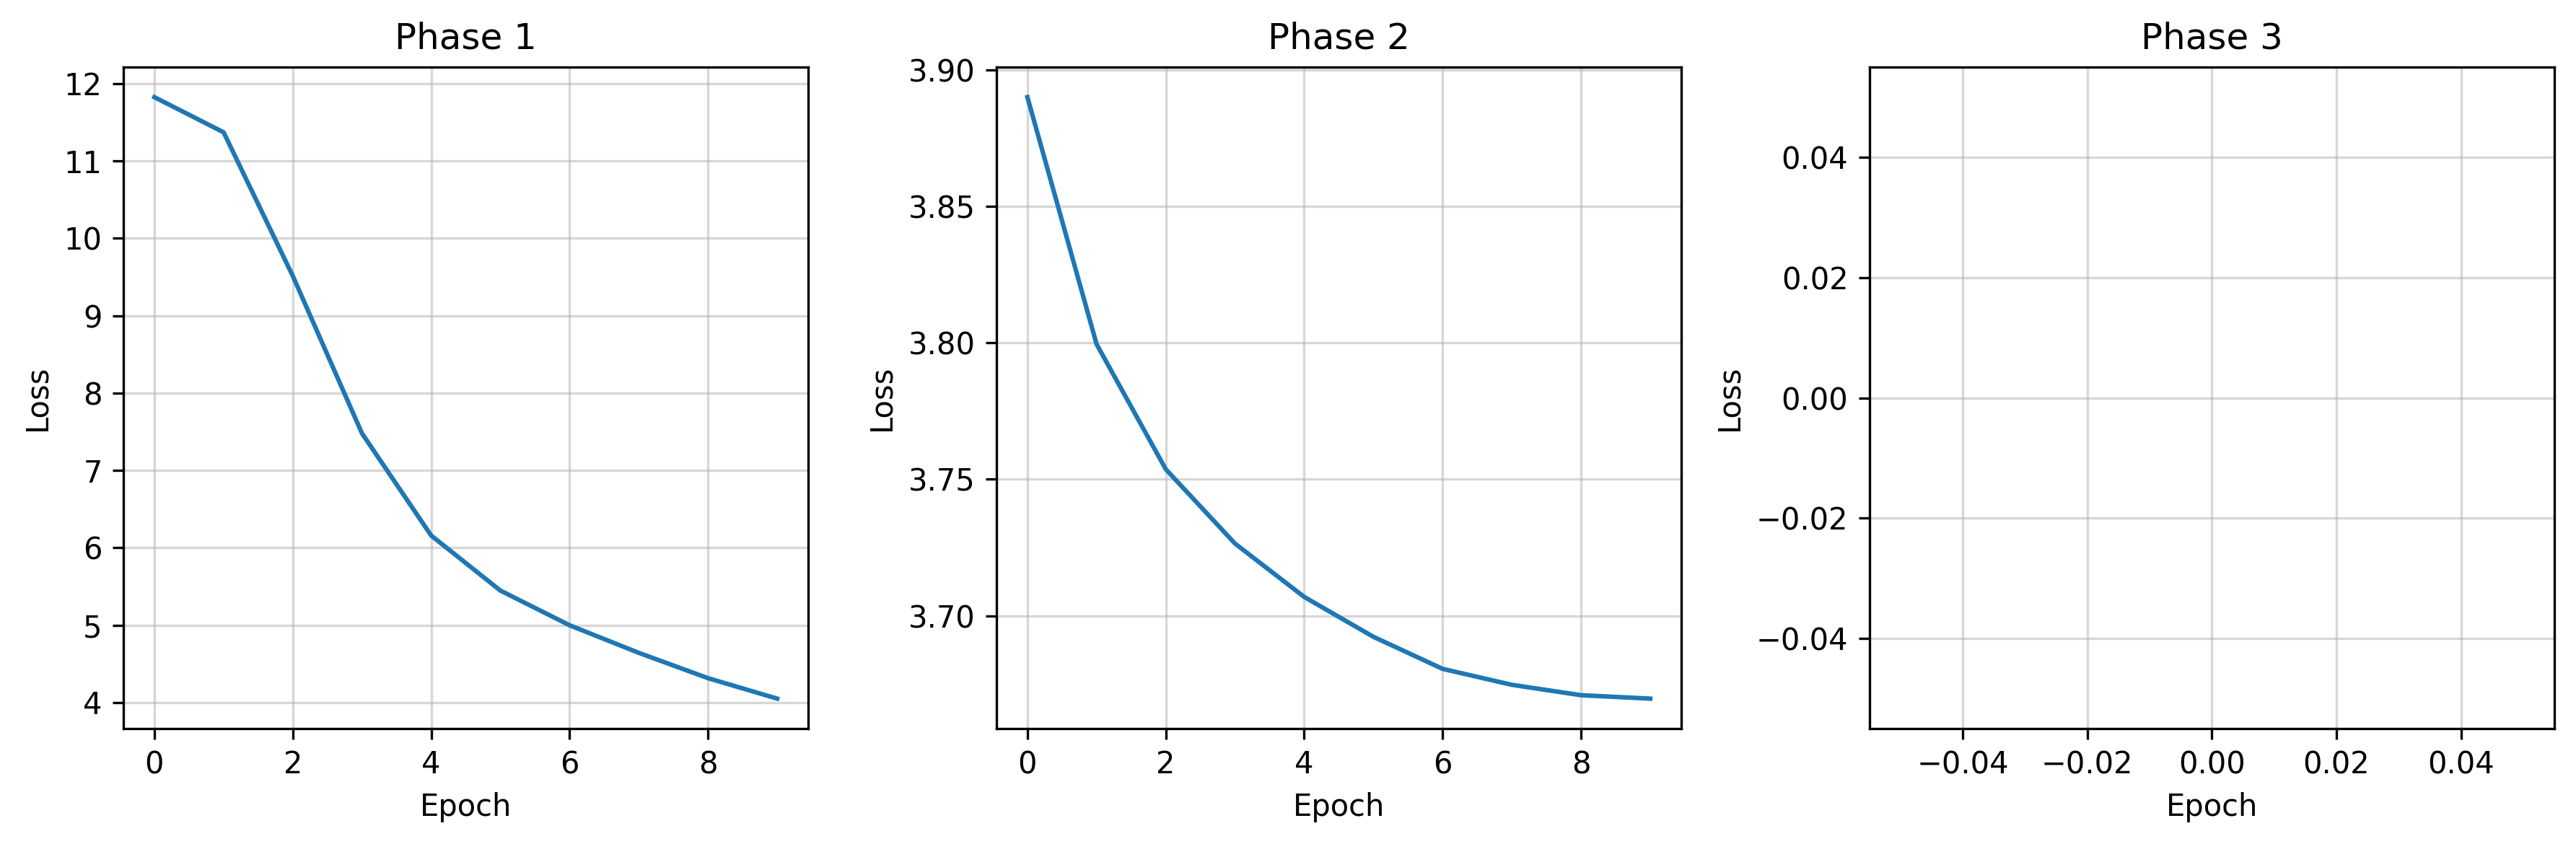

In [52]:
trainer.plot_training_loss()

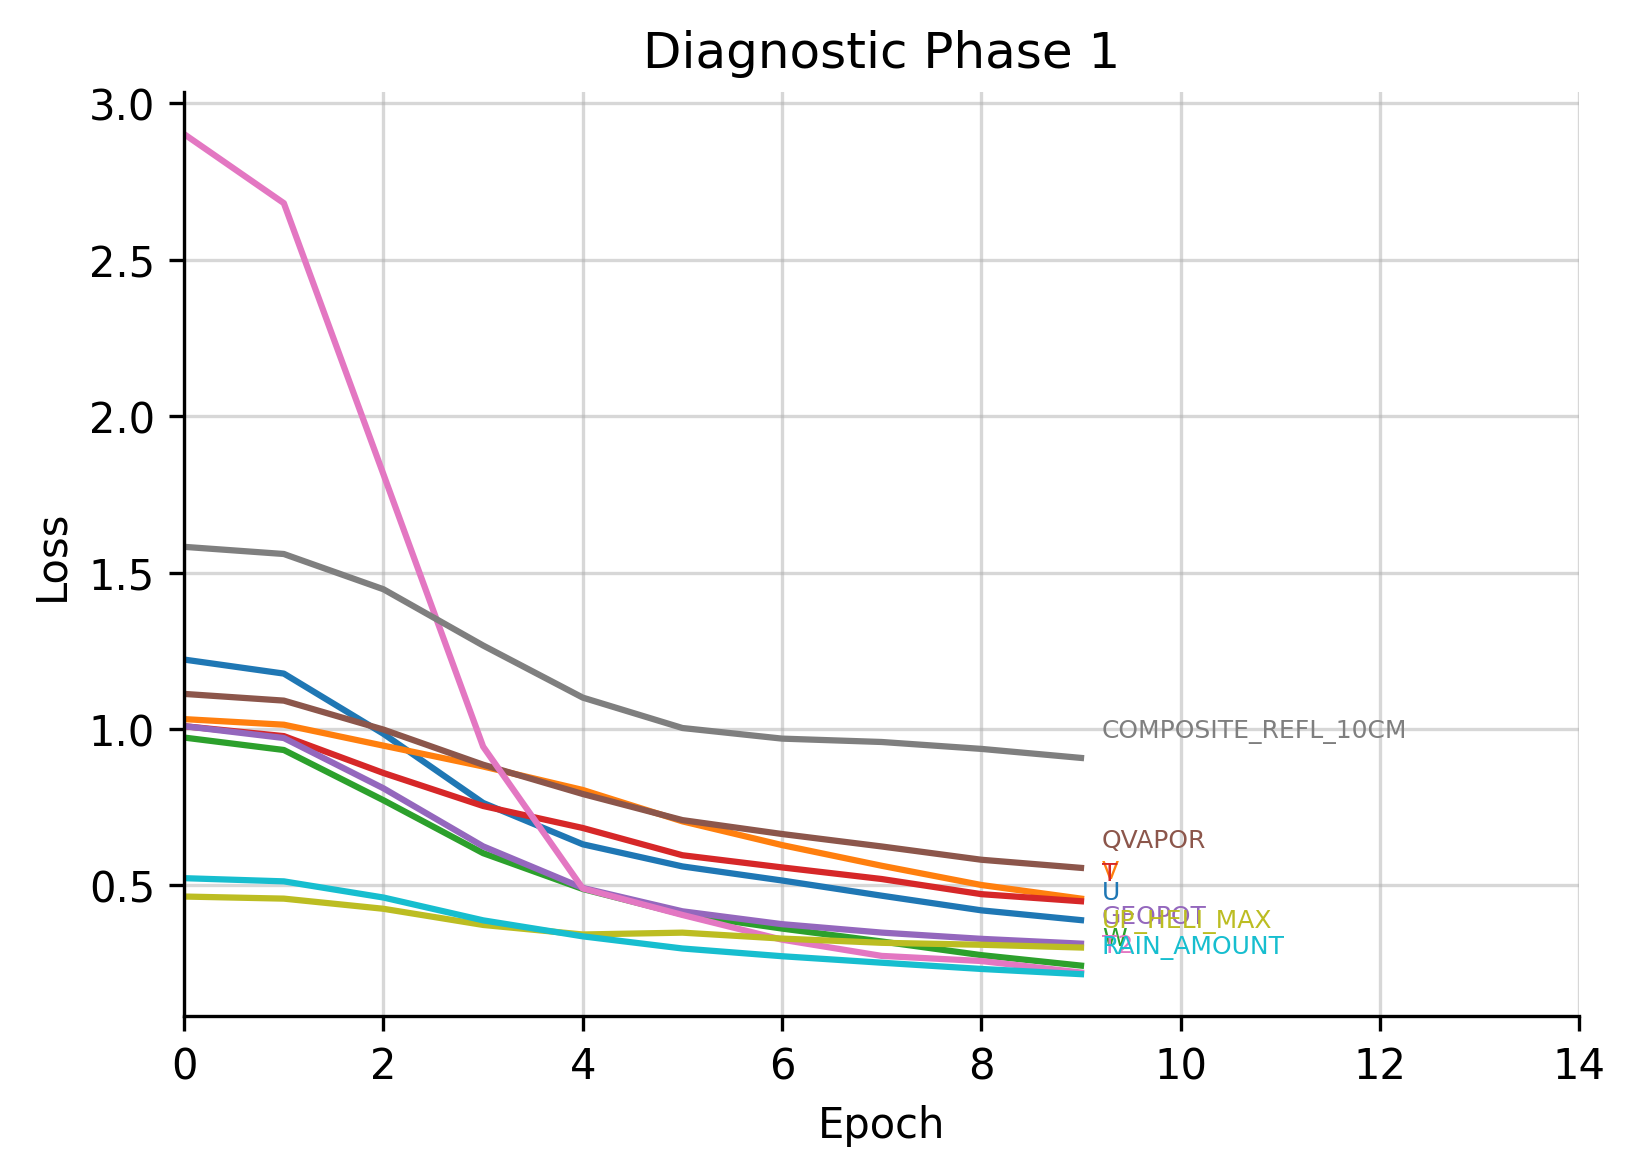

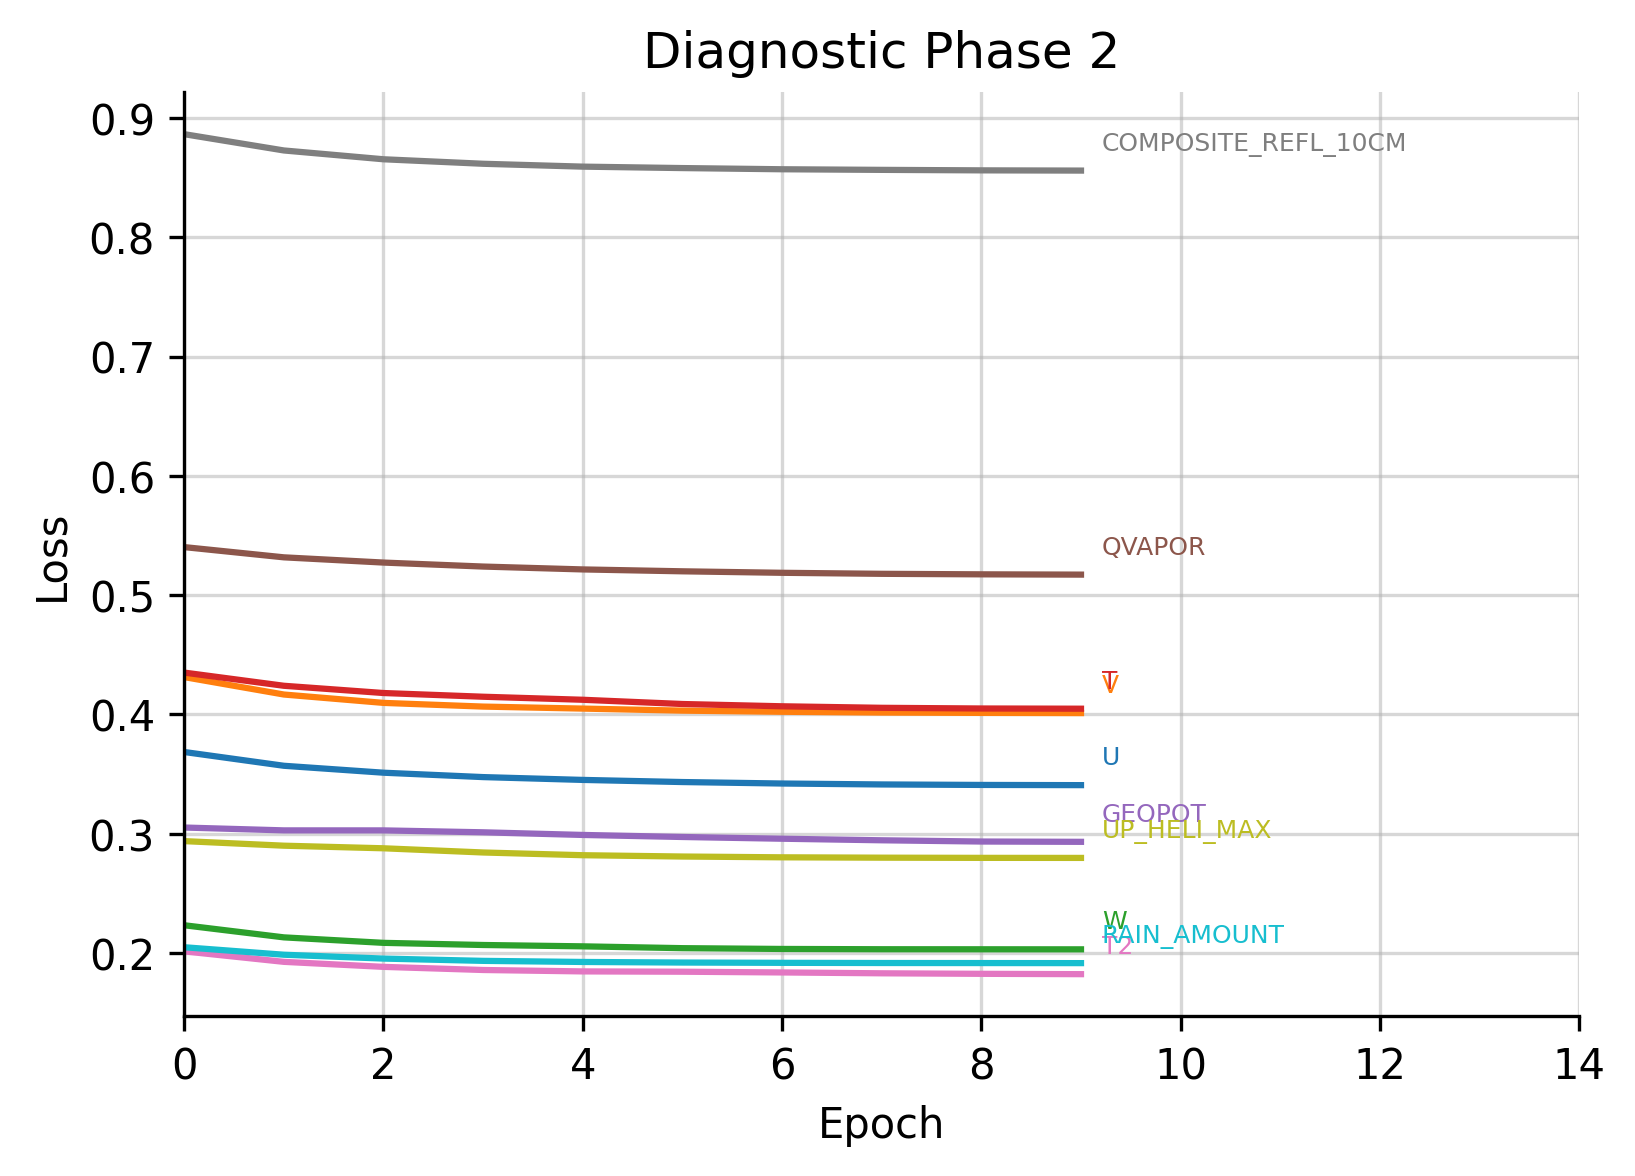

In [53]:
trainer.plot_diagnostics()